In [1]:
import numpy as np
import pandas as pd
import scipy as sc
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import math, time
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy import linalg

In [2]:
bostonData = load_boston()

In [3]:
bostonAsDataFrame = pd.DataFrame(bostonData.data)
print(bostonAsDataFrame.head())

        0     1     2    3      4      5     6       7    8      9     10  \
0  0.00632  18.0  2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0  15.3   
1  0.02731   0.0  7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0  17.8   
2  0.02729   0.0  7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0  17.8   
3  0.03237   0.0  2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0  18.7   
4  0.06905   0.0  2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0  18.7   

       11    12  
0  396.90  4.98  
1  396.90  9.14  
2  392.83  4.03  
3  394.63  2.94  
4  396.90  5.33  


In [4]:
bostonAsDataFrame.columns = bostonData.feature_names
print(bostonAsDataFrame.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33  


In [5]:
A = bostonAsDataFrame.as_matrix()
b = bostonData.target

In [6]:
def QRFactorizationUsingGramSchmidt(matrix):
    m, n = matrix.shape
    Q = np.zeros([m, n], dtype=np.float64)
    R = np.zeros([n, n], dtype=np.float64)
    for j in range(n):
        v = matrix[:, j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], matrix[:, j])
            v = v - (R[i, j] * Q[:, i])
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]
    return Q, R

In [7]:
def QRFactorizationUsingHausholder(matrix):
    m, n = matrix.shape
    R = np.copy(matrix)
    Q = np.eye(m)
    for k in range(n):
        v = np.copy(R[k:, k])
        v = np.reshape(v, (m-k, 1))
        v[0] += np.sign(v[0]) * np.linalg.norm(v)
        v /= np.linalg.norm(v)
        R[k:, k:] = R[k:, k:] - 2 * v @ v.T @ R[k:, k:]
        Q[k:] = Q[k:]-2 * v @ v.T @ Q[k:]
    R = R[0:n, 0:]
    Q = Q[0:n, 0:]
    return R, Q.T

In [8]:
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.4, random_state=10)

In [9]:
def ls_qrGS(A,b):
    Q, R = QRFactorizationUsingGramSchmidt(A)
    z= sc.linalg.solve_triangular(R, Q.T @ b)
    return z

In [10]:
def ls_qrHM(A,b):
    R, Q = QRFactorizationUsingHausholder(A)
    z= sc.linalg.solve_triangular(R, Q.T @ b)
    return z

In [11]:
A_tr = np.c_[A_train, np.ones(A_train.shape[0])]
A_te = np.c_[A_test, np.ones(A_test.shape[0])]

In [12]:
timeOfStart = time.time()
coeffs_GS = ls_qrGS(A_tr, b_train)
timeOfEnd = time.time()
timeNeededForCgsm = timeOfEnd - timeOfStart
print(timeNeededForCgsm)

0.015627145767211914


In [13]:
timeOfStart = time.time()
coeffs_HM = ls_qrHM(A_tr, b_train)
timeOfEnd = time.time()
timeNeededForHm = timeOfEnd - timeOfStart
print(timeNeededForHm)

0.015592575073242188


In [14]:
differenceBetweenTimesOfExecution = abs(timeNeededForCgsm - timeNeededForHm)
if timeNeededForCgsm < timeNeededForHm:
    print("Execution of Gram-Schmidt method takes %.10f seconds less" % differenceBetweenTimesOfExecution)
elif timeNeededForCgsm > timeNeededForHm:
    print("Execution of Householder method takes %.10f seconds less" % differenceBetweenTimesOfExecution)
else:
    print("Both methods take same amount of time to execute")

Execution of Householder method takes 0.0000345707 seconds less


In [16]:
Qcgsm, Rcgsm = QRFactorizationUsingGramSchmidt(A)
residualWithCgsm = np.linalg.norm(b-Qcgsm@Rcgsm@coeffs_GS)
print(residualWithCgsm)

ValueError: shapes (506,13) and (14,) not aligned: 13 (dim 1) != 14 (dim 0)

In [17]:
Rh, Qh = QRFactorizationUsingHausholder(A)
residualWithHm = np.linalg.norm(b-Qh@Rh@coeffs_HM)
print(residualWithHm)

ValueError: shapes (506,13) and (14,) not aligned: 13 (dim 1) != 14 (dim 0)

In [18]:
differenceBetweenResidual = abs(residualWithCgsm - residualWithHm)
if residualWithCgsm  < residualWithHm:
    print("Residual with Gram-Schmidt method is smaller", differenceBetweenResidual)
elif residualWithCgsm > residualWithHm:
    print("Residual with Householder method is smaller ", differenceBetweenResidual)     
else:
    print("Residuals are equal!")

NameError: name 'residualWithCgsm' is not defined

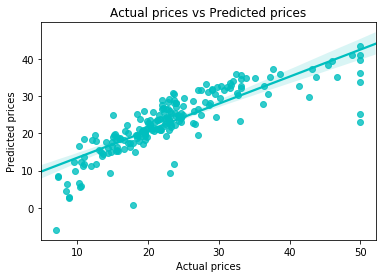

In [19]:
ax = sns.regplot(b_test,A_te@coeffs_HM, color='c')
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

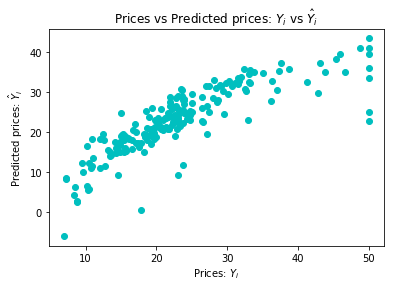

In [20]:
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.4, random_state=10)
lm = LinearRegression()
lm.fit(A_train, b_train)

Y_pred = lm.predict(A_test)

plt.scatter(b_test, Y_pred, color='c')
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()